# <b>Image features demo 2</b>

The AIServiceVisionClient offers the image <b>object detection</b> and <b>text detection</b> features. This notebook aims to provide overall clarity about the features to the user in terms of requirements, usage and the output of the API.<br>

<ul>
    <li>The raw output is saved as <code>response_image_demo2.json</code> in the <code>output</code> directory. </li>
    <li>Output image with bounding boxes is saved as <code>output_[input_file_name]</code> in the <code>output</code> directory. </li>
    <li>Object labels are printed in descending order of their confidence levels in the last cell of the notebook.</li>
<ul>

### Steps to run the notebook:
<details>
    <summary>Notebook session setup</summary>
    <ol>
        <li><font size="2">Installing the OCI Vision SDK</font></li>
        <li><font size="2">Installing other dependencies</font></li>
        <li><font size="2">Setup sample input images</font></li>
        <li><font size="2">Setup helper .py files</font></li>
        <li><font size="2">Create output folder</font></li>
    </ol>
</details>

<details>
    <summary>Importing the required modules</summary>
</details>

<details>
    <summary>Setting the input variables</summary>
     <font size="2">The user can change the input variables, if necessary. They have been assigned default values.</font>
</details>

<details>
    <summary>Running the main pipeline</summary>
    <font size="2">Run all cells to get the output in the <code>output</code> directory. </font><br>
</details>

### Notebook session setup
<details>
    <summary>Instructions</summary>
    <ul>
        <li><font size="2">The user needs to setup only once.</font></li>
        <li><font size="2">Uncomment the commented cells and run once to setup.</font></li>
        <li><font size="2">Comment back the same cells to avoid running again.</font></li>
    </ul>
</details>

#### Installing the OCI Vision SDK

In [1]:
# !wget "https://objectstorage.us-ashburn-1.oraclecloud.com/n/axhheqi2ofpb/b/vision-demo-notebooks/o/vision_service_python_client-0.3.45-py2.py3-none-any.whl"
# !pip install vision_service_python_client-0.3.45-py2.py3-none-any.whl
# !rm vision_service_python_client-0.3.45-py2.py3-none-any.whl

#### Installing other dependencies

In [2]:
# !pip install matplotlib==3.3.4
# !pip install pandas==1.1.5

#### Setup sample input images

In [3]:
# !wget "https://objectstorage.us-ashburn-1.oraclecloud.com/n/axhheqi2ofpb/b/vision-demo-notebooks/o/car.jpg"
# !mkdir data
# !mv car.jpg data

#### Setup helper .py files

In [4]:
# !wget "https://objectstorage.us-ashburn-1.oraclecloud.com/n/axhheqi2ofpb/b/vision-demo-notebooks/o/output_plot.py"
# !wget "https://objectstorage.us-ashburn-1.oraclecloud.com/n/axhheqi2ofpb/b/vision-demo-notebooks/o/analyze_image_utils.py"
# !mkdir helper
# !mv output_plot.py helper
# !mv analyze_image_utils.py helper

#### Create output folder

In [5]:
# !mkdir output

### Imports

In [6]:
import base64
import json
import io
import os
import requests
import oci
from PIL import Image
import matplotlib.pyplot as plt

from vision_service_python_client.ai_service_vision_client import AIServiceVisionClient
from vision_service_python_client.models.analyze_image_details import AnalyzeImageDetails
from vision_service_python_client.models.inline_image_details import InlineImageDetails
from vision_service_python_client.models.image_object_detection_feature import ImageObjectDetectionFeature
from vision_service_python_client.models.image_text_detection_feature import ImageTextDetectionFeature
from helper.output_plot import OutputPlot
from helper.analyze_image_utils import is_url, display_classes, clean_output

### Set input variables
<details>
<summary><font size="3">input_path</font></summary>
<font size="2">The user can provide the Image URL or filepath from the notebook session.</font><br>
</details>
<details>
<summary><font size="3">max_results</font></summary>
    <font size="2">Provide the maximum number of results needed for object detection. This is an upper limit over the output classes, the API may detect lesser classes according to the image.</font><br>
</details>

In [7]:
input_path = "data/car.jpg"
max_results = 5

### Authorize user config

In [8]:
config = oci.config.from_file('~/.oci/config')

### View input image

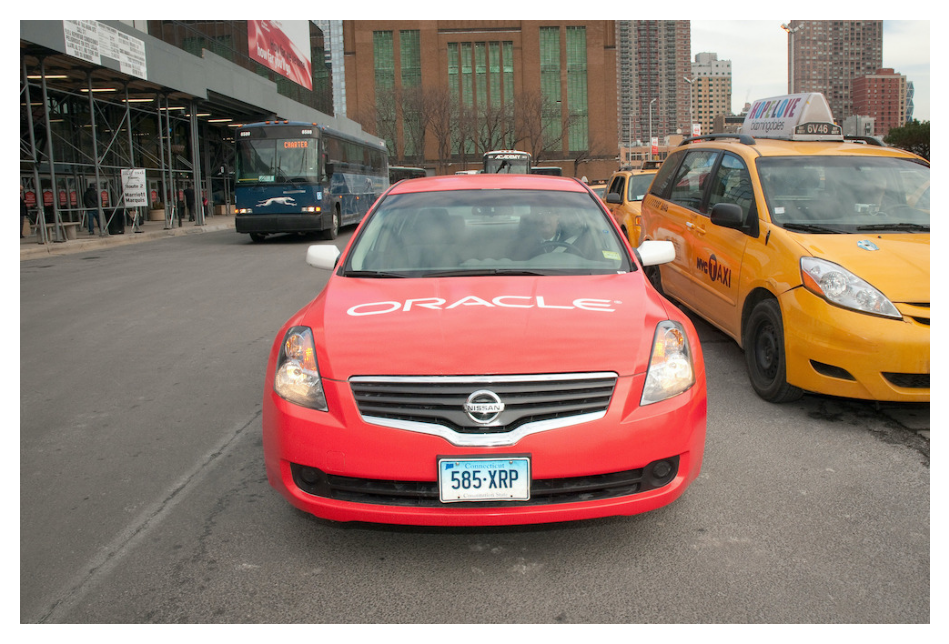

In [9]:
if is_url(input_path):
    encoded_string = base64.b64encode(requests.get(input_path).content)
else:
    with open(input_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())

image_data = base64.b64decode(encoded_string)
image = Image.open(io.BytesIO(image_data))
plt.gcf().set_dpi(200)
plt.axis('off')
plt.imshow(image)

### Create AI service vision client and get response object

In [10]:
ai_service_vision_client = AIServiceVisionClient(config=config)
analyze_image_details = AnalyzeImageDetails()
inline_image_details = InlineImageDetails()

image_object_detection_feature = ImageObjectDetectionFeature()
image_object_detection_feature.max_results = max_results
image_text_detection_feature = ImageTextDetectionFeature()
features = [image_object_detection_feature, image_text_detection_feature]
inline_image_details.data = encoded_string.decode('utf-8')
analyze_image_details.image = inline_image_details
analyze_image_details.features = features

res = ai_service_vision_client.analyze_image(analyze_image_details=analyze_image_details)

### Clean and save the API response as json

In [11]:
res_json = json.loads(repr(res.data))
clean_res = clean_output(res_json)
with open('output/response_image_demo2.json', 'w') as fp:
    json.dump(clean_res, fp)

### Add bounding boxes to the output image
The detected objects and text are annotated with <b>red</b> and <b>yellow</b> bounding boxes respectively.

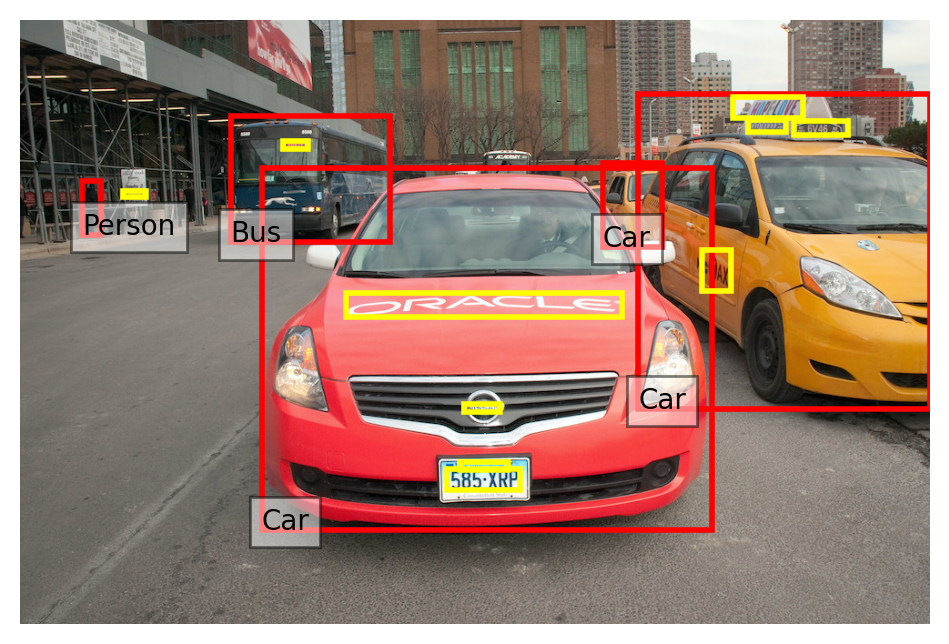

In [12]:
image_data = base64.b64decode(encoded_string)
image = Image.open(io.BytesIO(image_data))
output_plot = OutputPlot(image.width, image.height)
plt.gcf().set_dpi(200)
output_plot.plot.imshow(image)

box_properties = {}
if "image_objects" in clean_res:
    box_properties["linewidth"] = 2
    box_properties["edgecolor"] = 'red'
    output_plot.add_bounding_boxes(
        clean_res["image_objects"], True, box_properties)

if "image_text" in clean_res:
    box_properties["linewidth"] = 2
    box_properties["edgecolor"] = 'yellow'
    output_plot.add_bounding_boxes(clean_res["image_text"]["lines"], False, box_properties)
    
plt.axis('off')
plt.savefig("output/output_" + os.path.basename(input_path), dpi=200)

### Display the object labels with their confidence levels

In [13]:
if 'image_objects' in clean_res:
    display_classes(clean_res['image_objects'])

,Class,Confidence
1,Bus,0.989404
2,Car,0.985745
3,Car,0.982664
4,Person,0.966391
5,Car,0.954887


### Display the detected text with their confidence levels

In [15]:
if 'image_text' in clean_res:
    display_classes(clean_res['image_text']['lines'], 'Text')

,Text,Confidence
1,HOPELOVE,0.375000
2,Domingodes,0.056000
3,E 6V46,0.628500
4,CHARTER,0.994000
5,Marriott,0.260000
6,WYG DAXI,0.386500
7,ORACLE,0.975000
8,NISSAN,0.937000
9,Connecticut,0.244000
10,585.XRP,0.251000
